# OBJECTIVE : Exploratory Data Analysis, Classification

# DATASET
### Source : default of credit card clients Data Set ( https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients )
### Attribute Information:
````
This research employed a binary variable, default payment (Yes = 1, No = 0), as the response variable.  
This study reviewed the literature and used the following 23 variables as explanatory variables:  

X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.
X2: Gender (1 = male; 2 = female).
X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).
X4: Marital status (1 = married; 2 = single; 3 = others).
X5: Age (year).
X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows:a
    X6 = the repayment status in September, 2005;
    X7 = the repayment status in August, 2005;
    . . .;
    X11 = the repayment status in April, 2005.
    The measurement scale for the repayment status is:
        -1 = pay duly;
        1 = payment delay for one month;
        2 = payment delay for two months;
        . . .;
        8 = payment delay for eight months;
        9 = payment delay for nine months and above.
X12-X17: Amount of bill statement (NT dollar).
    X12 = amount of bill statement in September, 2005;
    X13 = amount of bill statement in August, 2005;
    . . .;
    X17 = amount of bill statement in April, 2005.
X18-X23: Amount of previous payment (NT dollar).
    X18 = amount paid in September, 2005;
    X19 = amount paid in August, 2005;
    . . .;
    X23 = amount paid in April, 2005.
````    

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [2]:
## import data

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

#drop columns we won't be using
train.drop(columns=['Unnamed: 0', 'ID'], inplace=True)
test.drop(columns=['Unnamed: 0', 'ID'], inplace=True)

train.rename(columns={'default payment next month': 'labels'}, inplace=True)
test.rename(columns={'default payment next month': 'labels'}, inplace=True)

:  
We make a convenience function to see improvement / deterioration  as we make changes to the features:  
<strong><em>F1 scores</em></strong>  
<strong><em>Accuracy</em></strong>  
<strong><em>Feature Importance</em></strong>

Simple sanity check to see if we are moving in the right direction.

We seperate 15% data from train data for validation, and evaluate the changes.

In [3]:

def see_current_scores(df, imps=False, graph=False):
    #train-val split
    x_train, x_val , y_train, y_val = train_test_split(df.iloc[:,:-1], df.iloc[:,-1],
                                                     test_size=0.15, random_state=43)
    # using RFC for benchmark
    rfc = RandomForestClassifier(n_estimators=20)
    rfc.fit(x_train, y_train)
    predictions = rfc.predict(x_val)
    print('Score from RFC:', rfc.score(x_val, y_val))
    print("F1 score from RFC:", f1_score(y_val, predictions))
    
    if (imps):
        feature_imps = {}
        print("\nFeature Importances:")
        ix = np.argsort(rfc.feature_importances_)[::-1]
        for i,j in zip(rfc.feature_importances_[ix],x_train.columns[ix]):
            print(i,j)
            feature_imps[j] = i
    
    if(graph):
        x = list(feature_imps.keys())
        y = list(feature_imps.values())
        plt.barh(x,y,log=True)
        plt.title('Feature Importance of features in Logarithm Scale')
        plt.show()

:  
Few convenience functions :P
  
show_cat_vs_labels()  
Must be used with Categorical features only.  
For any feature, it reports the ratio of defaulters / non-defaulters for each unique value in the feature.



In [5]:
def show_cat_vs_labels(df, col):
    vals = df[col].unique()
    vals.sort()
    for i in vals:
        try:
            bad_guys = df.labels[df[col] == i].value_counts()[1.0] # Defaulters
        except KeyError:
            bad_guys = 0
        try:
            good_guys = df.labels[df[col] == i].value_counts()[0] # Non-Defaulters
        except KeyError:
            good_guys = 0
        try:
            ratio = float(bad_guys) / float(good_guys)
        except ZeroDivisionError:
            ratio = 1
        print("for value {}, defaulter ratio:{}".format(i, ratio))


def plotit(df, col, kind='bar'):
    fig = plt.figure(figsize=(20,8))
    i=1
    
    vals = df[col].unique()
    vals.sort()
    
    for title in vals:
        fig.add_subplot(3, 5, i)
        plt.title('Val : {}'.format(title))
        df.labels[df[col] == title].value_counts().plot(kind=kind)
        i += 1
        
        
# for scaling data
def scaler(X):
    mean = X.mean(axis=0)
    std = X.std(axis=0)
    scaled_X = (X - mean) / std
    return scaled_X

Lets see the lower bound score on the dataset without doing anything

In [6]:
see_current_scores(train, imps=True)

Score from RFC: 0.8127413127413128
F1 score from RFC: 0.4589641434262948

Feature Importances:
0.10173049000167607 PAY_0
0.06493360079015578 AGE
0.06008414128426019 BILL_AMT1
0.058159193906207794 LIMIT_BAL
0.052628437039031625 BILL_AMT3
0.05211698808488724 BILL_AMT2
0.051076460539145094 PAY_AMT1
0.05072909686148479 BILL_AMT4
0.05019460540313847 PAY_2
0.0496997003913274 BILL_AMT6
0.04899367093800483 BILL_AMT5
0.04763905150312685 PAY_AMT2
0.04639232962982947 PAY_AMT6
0.04498821505215381 PAY_AMT5
0.04367346319711225 PAY_AMT3
0.042153586579447476 PAY_AMT4
0.03046614042789362 PAY_3
0.026254577593363453 PAY_5
0.020444159699063887 EDUCATION
0.01596010841996065 PAY_4
0.014989640100994298 MARRIAGE
0.013978521214065917 PAY_6
0.01271382134366903 SEX


#### Observations:  
 - The PAY_x features seem to be the most important

 - SEX, AGE, MARRIAGE & EDUCATION have least scores.
(Seems anybody can get in a difficult situation. :P)

 - We have PAY_0, and no PAY_1, strange!  

###    
### Analysing the Labels
Lets see the ratio of defaulters vs non-defaulters in the dataset.  
Value Mapping:  
0 : Non-Defaulters  
1 : Defaulters




Percentage of Class 1: 0.21842029045471473
Percentage of Class 0: 0.7815797095452853


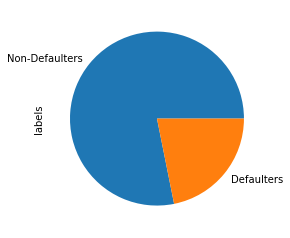

In [8]:
train.labels.value_counts().plot(kind='pie', labels=['Non-Defaulters', 'Defaulters'])

perc_1 = train.labels.value_counts()[1] / train.labels.count()
perc_0 = train.labels.value_counts()[0] / train.labels.count()

print('\nPercentage of Class 1:', perc_1)
print('Percentage of Class 0:', perc_0)



The data in hand is unbalanced as we have ~21% samples in class 1 and ~78% in class 0.  


### Exploring PAY_x features  

In [9]:
# See number of unique values in PAY_0
train['PAY_0'].unique()

array([ 2,  0, -1,  1, -2,  3,  4,  8,  7,  5,  6])

A lot of unique values ranging from -2 to 8.

Since <strong><em>-2</em></strong> value for PAY_x features are undocumented.  
Lets see how is the defaulters ratio ( # of defaulters / # of non-defaulters) for each uniques value in PAY_x attributes

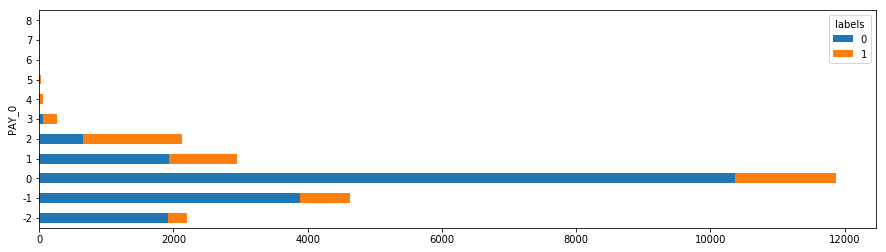

In [10]:
a = train.groupby(['labels', 'PAY_0']).count().unstack(0).PAY_2
a.plot(kind='barh', stacked=True, figsize=(15,4))
plt.show()

Well, the stacked barplot for PAY_0 showing defaulters looks a lot cluttered.  
Lets try something else. :p

for value -2, defaulter ratio:0.1456058242329693
for value -1, defaulter ratio:0.19074550128534704
for value 0, defaulter ratio:0.14481295796374855
for value 1, defaulter ratio:0.5195876288659794
for value 2, defaulter ratio:2.228787878787879
for value 3, defaulter ratio:3.3442622950819674
for value 4, defaulter ratio:2.388888888888889
for value 5, defaulter ratio:0.9166666666666666
for value 6, defaulter ratio:1.2
for value 7, defaulter ratio:2.0
for value 8, defaulter ratio:1.1428571428571428


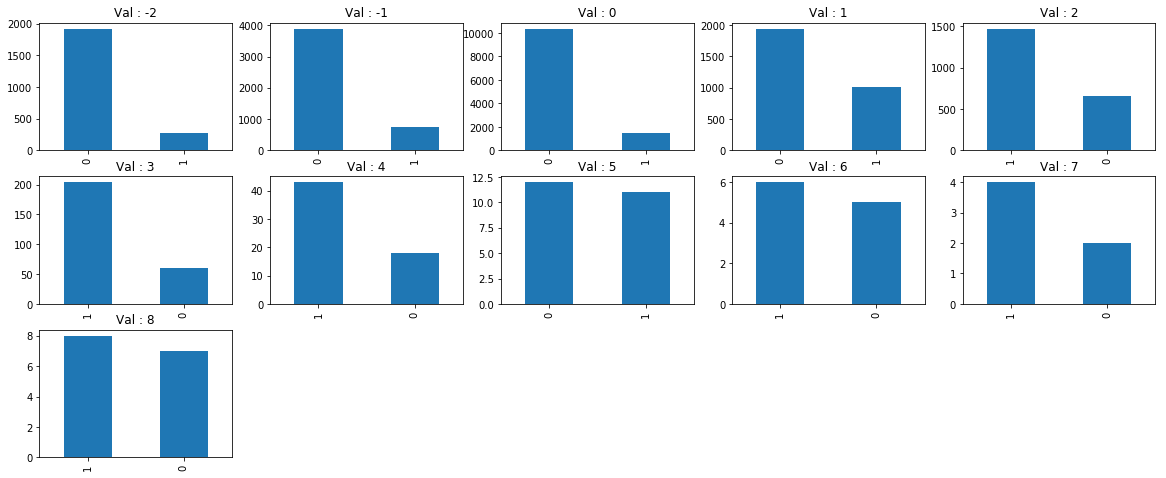

In [11]:
# Using the convenience functions we made above
show_cat_vs_labels(train, 'PAY_0')
plotit(train, 'PAY_0')


#### Observations  
We can now safely conclude that '-2' value for PAY_x attributes have very less defaulters ratio,  
as compared to positive values.  
So it might have a meaning similar to value '-1'. Could be pre-payment, or no debt or something else altogether.

### Exploring features: SEX, MARRIAGE, AGE & EDUCATION   
We saw above that these features have the least importances in predicting the labels from rfc.featuer_importances_  
Lets do some plotting to see their defaulters ratio.
  

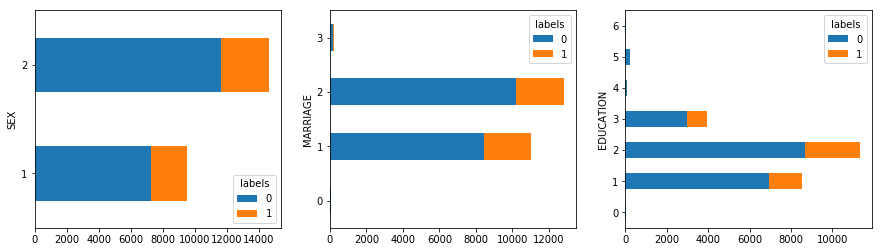


For feature SEX
for value 1, defaulter ratio:0.31461294328687733
for value 2, defaulter ratio:0.25757966159924417

For feature MARRIAGE
for value 0, defaulter ratio:0.10256410256410256
for value 1, defaulter ratio:0.3001298241472914
for value 2, defaulter ratio:0.2626877392755473
for value 3, defaulter ratio:0.2931937172774869

For feature EDUCATION
for value 0, defaulter ratio:0.0
for value 1, defaulter ratio:0.2332175925925926
for value 2, defaulter ratio:0.3085635039870565
for value 3, defaulter ratio:0.3261744966442953
for value 4, defaulter ratio:0.060240963855421686
for value 5, defaulter ratio:0.055299539170506916
for value 6, defaulter ratio:0.2222222222222222


In [12]:

fig, (a1,a2,a3) = plt.subplots(ncols=3, figsize=(15,4))

train.groupby(['labels', 'SEX']).count().unstack(0).PAY_2.plot(kind='barh', stacked=True, ax=a1)
train.groupby(['labels', 'MARRIAGE']).count().unstack(0).PAY_2.plot(kind='barh', stacked=True, ax=a2)
train.groupby(['labels', 'EDUCATION']).count().unstack(0).PAY_2.plot(kind='barh', stacked=True, ax=a3)
plt.show()

print('\nFor feature SEX')
show_cat_vs_labels(train, 'SEX')

print('\nFor feature MARRIAGE')
show_cat_vs_labels(train, 'MARRIAGE')

print('\nFor feature EDUCATION')
show_cat_vs_labels(train, 'EDUCATION')


:  
Seems Men are more likely to default payment, as they have a little higher defaulting ratio.  
But still SEX as a feature score very little in the RFC feature importance.  
:  

**_Overall defaulter ratio of the dataset ( 21.84 / 78.15 ~ 0.27 )  {i.e. # samples with class labels 1 / # samples with class labels 0}_**  
  
**One important thing worth noticing would be that if the defaulter ratio for any value in any feature is very close to the overall defaulter ratio of the dataset ( 21.84 / 78.15 ~ 0.27 ), then it probably is not going to be a very useful thing for us.  
The farther the defaulter ratio is from 0.27, the better.**  
  

The information we observe here is very coherent with the feature importance from RFC we observed above.  
SEX and MARRIAGE have their defaulter ratios very close around 0.27
EDUCATION has its ratios much farther than 0.27.


What we will try next is removeing these features altogether, and see the performance dip/rise.

In [13]:
train_low_features_removed = train.drop(columns=['SEX', 'MARRIAGE'])

In [14]:
see_current_scores(train_low_features_removed)
see_current_scores(train)


Score from RFC: 0.8124655267512411
F1 score from RFC: 0.4568690095846646
Score from RFC: 0.8116381687810259
F1 score from RFC: 0.45577689243027886


A very slight dip in F1 score after removing SEX & MARRIAGE, as compared to the previous result with no change in dataset.  
But we cannot be too sure of that.  
We keep the features for now and decide later whether to keep or discard them.

### Lets Create New features

The features BILL_AMTx are the amount the credit card holder is billed each month from April to September.
And PAY_AMTx are the payments the person makes from April to September.

One thing we can infer from the data is the relation between BILL_AMTx and PAY_AMTx.


In [15]:
#print(train.columns)

sample = train.iloc[[18,26,58,61],:][['PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']]

bills = sample.values[:,6:12]
payments = sample.values[:,12:18]
delta = bills[:,1:] - payments[:,:-1]
print('Delta values for chosen samples for 5 months:\n',delta)
sample

Delta values for chosen samples for 5 months:
 [[   0    0    0    0    0]
 [  -5  -15    0    0 -369]
 [   0    0    0    0    0]
 [-163 -116  -23 -399 -129]]


,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
18,-1,-1,-1,-1,-1,-1,316,316,316,0,632,316,316,316,0,632,316,0
26,-1,-1,-1,-1,-1,-1,16646,17265,13266,15339,14307,36923,17270,13281,15339,14307,37292,0
58,-1,-1,-1,-1,-1,-1,780,0,390,390,390,390,0,390,390,390,390,390
61,-1,-1,-1,-1,-1,-1,3048,5550,23337,4291,80153,25820,5713,23453,4314,80552,25949,2016


:  
:    
:  
We have deliberately chosen sample #18, #26, #58, #61 to understand this, since they have -1 {paid duly} for all 6 months.  
So BILL_AMT6 is bill generated for April & PAY_AMT5 is the payment made in May for April's bill.  
So delta that these good people maintain every month ( sample #18, #26, #58, #61) is almost 0 every month.  
And a negative delta value means they are making pre-payments.
  
Using this observation, we can have the delta that each person maintains for a maximum of 5 months.  
(Since PAY_AMT6 is payment made in April, for March's bill, whose data we do not have.)  
(BILL_AMT1 is bill generated in September, but we do not have payment amount for this bill.)  
  
We will add a new column in the data which is the mean of the delta for the 5 months and see its feature importance. 


In [16]:
def add_delta_feature(df):
    bills = df[['BILL_AMT1', 'BILL_AMT2','BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].values
    payments = df[['PAY_AMT1','PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].values
    limit = df[['LIMIT_BAL']].values
    delta  = bills[:,1:] - payments[:,:-1]
    delta = delta.mean(axis=1)

    df_with_delta =  df.copy()
    df_with_delta.insert(loc=5, column='delta_mean', value=delta)
    return df_with_delta

train = add_delta_feature(train)
test = add_delta_feature(test)
#Apply same operations to test data too


In [18]:
see_current_scores(train, imps=True)

Score from RFC: 0.8121897407611693
F1 score from RFC: 0.45563549160671457

Feature Importances:
0.10182246329939608 PAY_0
0.06346249868570246 AGE
0.05858965107577814 LIMIT_BAL
0.056285712889108795 BILL_AMT1
0.050843693269095235 BILL_AMT2
0.04909000096905615 PAY_2
0.04867278655607252 PAY_AMT1
0.04758642992150779 delta_mean
0.046353660987922686 BILL_AMT6
0.04621554522174788 BILL_AMT4
0.04604603193116033 BILL_AMT5
0.046038954518434164 BILL_AMT3
0.04481347155083152 PAY_AMT2
0.04374309870906693 PAY_AMT6
0.043154915327486804 PAY_AMT3
0.041427396693379095 PAY_AMT5
0.039540913911670396 PAY_AMT4
0.024480258412383323 PAY_3
0.02010501902674928 EDUCATION
0.01992435703963989 PAY_4
0.018938078882823492 PAY_6
0.017917493702736167 PAY_5
0.013444746948429644 MARRIAGE
0.011502820469821248 SEX


So, our new feature **delta_mean** has captured some meaningful information from PAY_AMTx and BILL_AMTx.  
It is **9th most important feature among 25 features**.  
{ THIS RANK MAY VARY WITH EACH RUN}

### Done with the features, move to model
#### Lets do some tuning with RandomForestClassifier
Some local hyperparameter search on RandomForestClassifier usinf sklearn's GridCVSearch returned the following parameters for RFC when scored on accuracy.
 - max_depth : 7
 - criterion : 'gini'
 - n_estimators : 75

In [19]:
rfc = RandomForestClassifier(max_depth=7, criterion='gini', n_estimators=75)
x_train, x_val , y_train, y_val = train_test_split(train.iloc[:,:-1], train.iloc[:,-1],
                                                     test_size=0.15, random_state=43)

rfc.fit(x_train, y_train)
predictions = rfc.predict(x_val)
predict_proba = rfc.predict_proba(x_val)
print('Score from RFC:', rfc.score(x_val, y_val))
print("F1 score from RFC with probability threshold 0.5:", f1_score(y_val, predictions))


Score from RFC: 0.8196359624931053
F1 score from RFC with probability threshold 0.5: 0.4612850082372323


### Tune the threshold for making predictions  
#### Instead of making a class label prediction with probability threshold = 0.5.  
#### We shift the threshold and see the effect on F1 score & Accuracy.

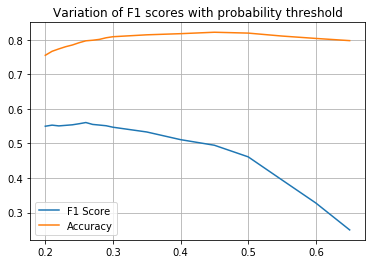



Maximum F1 score obtained with threshold 0.26 is 0.5606694560669456


In [20]:

fscores = {}
accuracy = {}
T = [0.20, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.30, 0.35, 0.4, 0.45, 0.5, 0.55, 0.60, 0.65]
for t in T:
    predictions=[]
    for i in predict_proba:
        if(i[1] > t):
            predictions.append(1)
        else:
            predictions.append(0)
    predictions = np.array(predictions)
    accuracy[t] = 1 - (predictions - y_val).abs().sum() / predictions.shape[0]
    fscores[t] = f1_score(y_val, predictions)

fscores_list = list(fscores.values())
accuracy_list = list(accuracy.values())
max_T = T[np.argmax(fscores_list)]
max_F1 = fscores[max_T]
    
plt.plot(T, fscores_list, label='F1 Score')
plt.plot(T,accuracy_list, label='Accuracy')
plt.legend()
plt.title('Variation of F1 scores with probability threshold')
plt.grid()
plt.show()

print("\n\nMaximum F1 score obtained with threshold {} is {}".format(max_T, max_F1))

###  
###  
### Now we have everything in place. Lets train RFC with all training data and generate the predictions for test data

In [21]:
X_train = train.iloc[:,:-1]
Y_train = train.iloc[:,-1]

rfc.fit(X_train, Y_train)
predictions_05 = rfc.predict(test)
predict_proba = rfc.predict_proba(test)


predictions_maxT=[]
for i in predict_proba:
    if(i[1] > max_T):
        predictions_maxT.append(1)
    else:
        predictions_maxT.append(0)
predictions_05 = np.array(predictions_05)
predictions_maxT = np.array(predictions_maxT)



###  
Write the predictions to test.csv

In [22]:
test_orig = pd.read_csv('test.csv')
test_orig['Prediction'] = predictions_maxT
test_orig.to_csv('test.csv')